In [1]:
import pandas as pd
import torch

from netam import framework, models

import sys
sys.path.append('..')
from shmex.shm_data import load_shmoof_dataframes, pcp_df_of_non_shmoof_nickname, dataset_dict

from netam.common import nt_mask_tensor_of

In [2]:
shmoof_path = dataset_dict["shmoof"]
df = pd.read_csv(shmoof_path)

df = df[df["parent"] != df["child"]]

frac_long_seqs = (df["parent"].str.len() > 410).sum() / len(df)
print(f"Fraction of long sequences: {frac_long_seqs:.2g}")

Fraction of long sequences: 0.0036


In [3]:
df["sample_id"].value_counts()

sample_id
326651    22424
326713    13186
327059     4686
316188     3067
326797     3028
326780     1573
326737      442
326650      324
326907      286
Name: count, dtype: int64

In [4]:
# set nickname to be the last two characters of sample_id
df["nickname"] = df["sample_id"].astype(str).str[-2:]

for small_nickname in ["80", "37", "50", "07"]:
    df.loc[df["nickname"] == small_nickname, "nickname"] = "small"

nicknames = df["nickname"].unique()

df["nickname"].value_counts()

nickname
51       22424
13       13186
59        4686
88        3067
97        3028
small     2625
Name: count, dtype: int64

<Axes: ylabel='Proportion'>

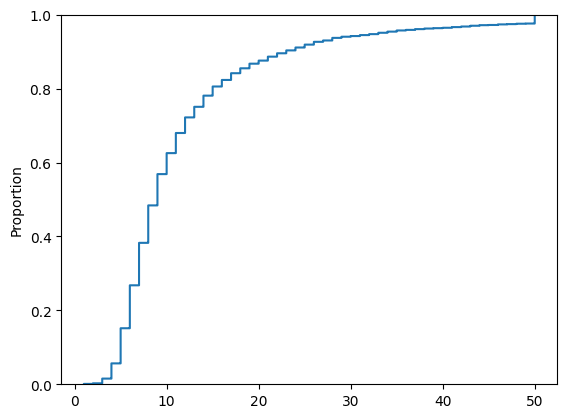

In [5]:
len(df["family"].unique()) 
# groupy family
# empirical CDF of df.groupby("family").size()
import seaborn as sns
# sns.ecdfplot(df.groupby("family").size()) restricted to max of 50
sns.ecdfplot(df.groupby("family").size().clip(upper=50))    

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

def mutation_count_of_row(row):    
    return sum(
        1 for p, c in zip(row["parent"], row["child"]) if p != c and p != "N" and c != "N"
    )    

mutation_counts = {nickname: [] for nickname in nicknames}

for nickname in nicknames:
    _, val_df = load_shmoof_dataframes(shmoof_path, val_nickname=nickname)  # Load the dataframe
    val_df['mutation_count'] = val_df.apply(mutation_count_of_row, axis=1)
    mutation_counts[nickname] = val_df['mutation_count'].tolist()

tang_df = pcp_df_of_non_shmoof_nickname("tangshm")
mutation_counts["tang"] = tang_df.apply(mutation_count_of_row, axis=1)


Loading /Users/matsen/data/v1/tang-deepshm-oof_pcp_2024-04-09_MASKED_NI.csv.gz


In [7]:
# compute summary stats of the length of tang_df["parent"]
tang_df["parent"].str.len().describe()
# how many sequences are longer than 500
(tang_df["parent"].str.len() > 500).sum()

2

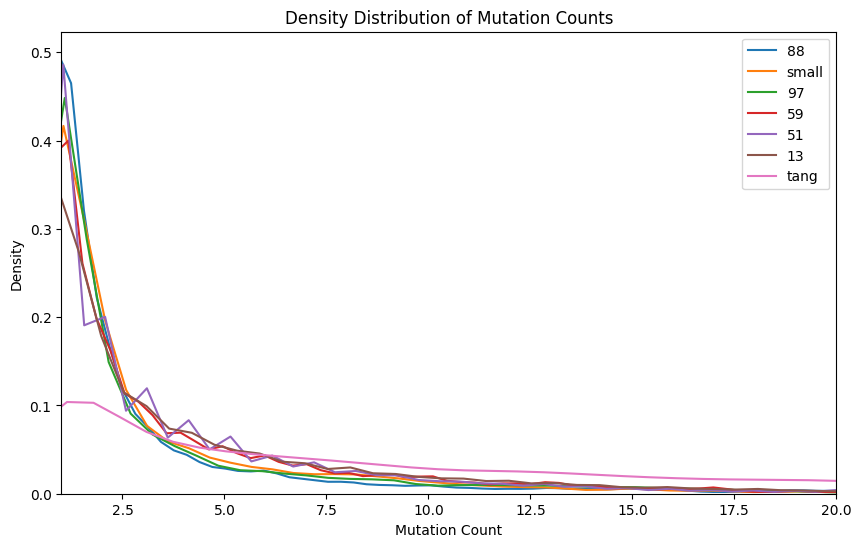

In [8]:
import seaborn as sns

plt.figure(figsize=(10, 6))
for nickname, counts in mutation_counts.items():
    sns.kdeplot(counts, label=nickname, bw_adjust=0.5)

plt.xlim(1, 20)
plt.xlabel('Mutation Count')
plt.ylabel('Density')
plt.title('Density Distribution of Mutation Counts')
plt.legend()
plt.show()
